# Analyser et classer des données avec les k-plus proches voisins

Le seul algorithme d'IA présent en NSI est l'algorithme des k-plus proches voisins. Malgré cette limitation, il est possible de sensibiliser aux enjeux propres à l'IA. Le but de cette activité est d'apporter un peu de hauteur de vue autour de ces questions.

**Le code présenté n'a pas vocation à être enseigné directement en NSI.**

De nombreuses parties de ce notebook sont destinées à être reprises en dehors du temps de l'atelier.

## 1 - Présentation du problème et traitement des données

On considère ici le problème suivant : étant donné des mesures médicales, peut-on déterminer si un patient est atteint du diabète ?

Le jeu de données est le Pima Indians Diabetes Database qui fournit 768 mesures associées à des femmes issues de la communauté nord-amérindienne des Pima dont la présence de diabète et d'obésité a été un sujet d'études.

In [736]:
import numpy as np
import matplotlib.pyplot as plt

In [737]:
# Lecture des donnees sous la forme d'un tableau de tuples nommés
import csv
def conversion_flottants(d):
    return { k : float(v) for k, v in d.items() }
    
with open('diabetes.csv') as csvfile:
    lecteur = csv.DictReader(csvfile)
    donnees = [ conversion_flottants(donnee) for donnee in lecteur ]

donnees

[{'Pregnancies': 6.0,
  'Glucose': 148.0,
  'BloodPressure': 72.0,
  'SkinThickness': 35.0,
  'Insulin': 0.0,
  'BMI': 33.6,
  'DiabetesPedigreeFunction': 0.627,
  'Age': 50.0,
  'Outcome': 1.0},
 {'Pregnancies': 1.0,
  'Glucose': 85.0,
  'BloodPressure': 66.0,
  'SkinThickness': 29.0,
  'Insulin': 0.0,
  'BMI': 26.6,
  'DiabetesPedigreeFunction': 0.351,
  'Age': 31.0,
  'Outcome': 0.0},
 {'Pregnancies': 8.0,
  'Glucose': 183.0,
  'BloodPressure': 64.0,
  'SkinThickness': 0.0,
  'Insulin': 0.0,
  'BMI': 23.3,
  'DiabetesPedigreeFunction': 0.672,
  'Age': 32.0,
  'Outcome': 1.0},
 {'Pregnancies': 1.0,
  'Glucose': 89.0,
  'BloodPressure': 66.0,
  'SkinThickness': 23.0,
  'Insulin': 94.0,
  'BMI': 28.1,
  'DiabetesPedigreeFunction': 0.167,
  'Age': 21.0,
  'Outcome': 0.0},
 {'Pregnancies': 0.0,
  'Glucose': 137.0,
  'BloodPressure': 40.0,
  'SkinThickness': 35.0,
  'Insulin': 168.0,
  'BMI': 43.1,
  'DiabetesPedigreeFunction': 2.288,
  'Age': 33.0,
  'Outcome': 1.0},
 {'Pregnancies': 5.0

Dans ce jeu de données, il y a 8 champs associés à des valeurs numériques et un champ `Outcome` valant 1 ou 0 selon que la personne soit atteinte de diabète ou non.

Pour traiter les données, on va

* passer d'un tableau de tuples nommés à deux tableaux :
   * `carac` composé de tableaux de valeurs numériques observées ;
   * `etiq` composé des étiquettes de classification, ici `0` ou `1` selon le fait d'être atteint ou non du diabète ;
* sélectionner une partie des données pour l'entrainement et une partie pour la vérification de l'efficacité, on parle de jeu d'entraînement et de jeu de tests.

In [738]:
champs = ['Pregnancies', 'Glucose', 'BloodPressure',
        'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

def valeurs(donnee):
    return [ donnee[k] for k in champs ]

carac = [ valeurs(donnee) for donnee in donnees ]
etiq = [ int(donnee['Outcome']) for donnee in donnees ]

In [739]:
def separe_entrainement_test(carac, etiq, ratio):
    sep = int(len(carac)*ratio)
    carac_e, carac_t = carac[:sep], carac[sep:]
    etiq_e, etiq_t = etiq[:sep], etiq[sep:]
    return carac_e, etiq_e, carac_t, etiq_t

In [753]:
carac_e, etiq_e, carac_t, etiq_t = separe_entrainement_test(carac, etiq, 0.75)

* **Question** : en pratique, on mélange avant la séparation, pourquoi ?
* **Question** : que risque-t-il de se passer si `ratio` est trop petit ? trop grand ?

# Les classificateurs

Un classificateur (*classifier* en anglais) va partir d'un couple `(carac, etiq)` de données d'entrainement, s'initialiser pour s'aligner à ces données (on parle de *fit*) et permettre ensuite de prédire l'étiquette d'une valeur.

Certains classificateurs sont dits *sans modèle*, car ils se contentent d'utiliser le couple de données d'entrainement pour prédire. Pour avoir une ligne de comparaison, on va considérer deux classificateurs sans modèle *naïfs* :

* le classificateur `Aleatoire` qui renvoie une étiquette aléatoire parmi les étiquettes des données d'entrainement ;
* le classificateur `Majoritaire` qui renvoie l'étiquette la plus présente.

In [775]:
class ClassificateurSansModele:
    '''Une classe abstraite dont on peut hériter mais qui nécessite
    de rédefinir predict_one'''
    def __init__(self):
        self.donnees = None
    def fit(self, carac, etiq):
        self.donnees = (carac, etiq)
    def predict_one(self, v):
        raise ValueError
    def predict(self, cible):
        return [ self.predict_one(v) for v in cible ]

from random import choice

class Aleatoire(ClassificateurSansModele):
    def predict_one(self, v):
        return choice(self.donnees[1])

from statistics import mode

class Majoritaire(ClassificateurSansModele):
    def predict_one(self, v):
        return mode(self.donnees[1])

L'algorithme des k-plus proches voisins, ou kNN, est un classificateur sans modèle qui prédit l'étiquette en prenant l'étiquette majoritaire parmi les k données les plus proches. Il y a donc deux paramètres le nombre `k`, impair pour avoir une étiquette majoritaire dans le cas il y a deux classes, et la distance.

In [776]:
import math

# la distance euclidienne, mais on peut utiliser d'autres distances
def dist(p1, p2):
    return math.sqrt(sum( (c1-c2)**2 for c1, c2 in zip(p1,p2)))

class KNN(ClassificateurSansModele):
    def __init__(self, k):
        super().__init__()
        self.k = k

    def predict_one(self, v):
        indices = list(range(len(self.donnees[0])))
        indices.sort(key= lambda i: dist(self.donnees[0][i], v))
        plus_proches = [ self.donnees[1][i] for i in indices[:self.k] ]
        classes = list(set(self.donnees[1]))
        classes.sort(key=lambda c: plus_proches.count(c))
        return classes[-1]

Pour estimer la précision d'un classificateur, on va prédire l'ensemble du jeu de tests et calculer le pourcentage de bonnes prédictions.

In [805]:
def calcule_precision(cible, valeurs):
    score = 0
    n = len(cible)
    for i in range(n):
        if cible[i] == valeurs[i]:
            score += 1
    return score / n

In [810]:
def evalue_classificateur(classificateur, carac_e, etiq_e, carac_t, etiq_t):
    classificateur.fit(carac_e, etiq_e)
    etiq_pred = classificateur.predict(carac_t)
    return calcule_precision(etiq_t, etiq_pred)

In [811]:
evalue_classificateur(Aleatoire(), carac_e, etiq_e, carac_t, etiq_t)

0.5833333333333334

In [812]:
evalue_classificateur(Majoritaire(), carac_e, etiq_e, carac_t, etiq_t)

0.6354166666666666

In [813]:
evalue_classificateur(KNN(3), carac_e, etiq_e, carac_t, etiq_t)

0.6979166666666666

In [814]:
evalue_classificateur(KNN(11), carac_e, etiq_e, carac_t, etiq_t)

0.71875

La bibliothèque `scikit-learn` fourni un tel classificateur avec une interface proche de celle que nous avons utilisé.

In [815]:
from sklearn.neighbors import KNeighborsClassifier

In [816]:
evalue_classificateur(KNeighborsClassifier(n_neighbors=3), carac_e, etiq_e, carac_v, etiq_v)

0.6979166666666666

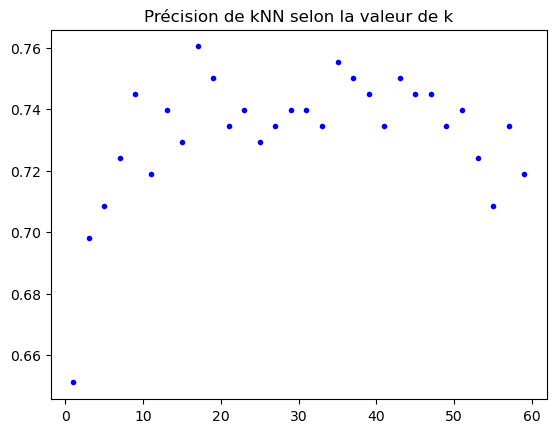

In [817]:
k_s = [ 2*i+1 for i in range(30) ]
plt.plot( k_s, [ evalue_classificateur(KNeighborsClassifier(k), carac_e, etiq_e, carac_v, etiq_v) for k in k_s ], 'b.' )
plt.title('Précision de kNN selon la valeur de k')
plt.show()

* **Question** que remarque-t-on sur la précision en fonction de `k` ? Peut-on l'expliquer ?

Les réseaux de neurones sont un classificateur avec modèle. `scikit-learn` propose un tel classificateur `MLPClassifier`, pour *multi-layer perceptron classifier`. Ici, la phase de `fit` va réaliser l'entrainement du réseau. Pour le faible nombre de données, on effectue un nombre conséquent d'itérations pour garantir la convergence du modèle.

In [818]:
from sklearn.neural_network import MLPClassifier
evalue_classificateur(MLPClassifier(max_iter=1000), carac_e, etiq_e, carac_v, etiq_v)

0.6666666666666666

In [822]:
def compare_classificateurs(carac, etiq, ratio):
    carac_e, etiq_e, carac_v, etiq_v = separe(carac, etiq, ratio)
    
    classificateurs = {
        'Aleatoire' : Aleatoire(),
        'Mediane' : Mediane(),
        'kNN-3' : KNN(3),
        'kNN-11' : KNN(11),
        'Réseau de neurones' : MLPClassifier(max_iter=1000),
    }
    
    precisions = {
        k : evalue_classificateur(v, carac_e, etiq_e, carac_v, etiq_v)
        for k,v in classificateurs.items()
    }
    
    plt.figure(figsize=(10, 6))
    plt.bar(precisions.keys(), precisions.values())
    
    plt.title('Comparaison de la précision des classificateurs')
    plt.xlabel('Classificateurs')
    plt.ylabel('Précision')
    
    for i, (k, pr) in enumerate(precisions.items()):
        plt.text(i, pr, f"{pr:.2f}", ha='center')
    
    plt.ylim(0, 1)
    plt.show()

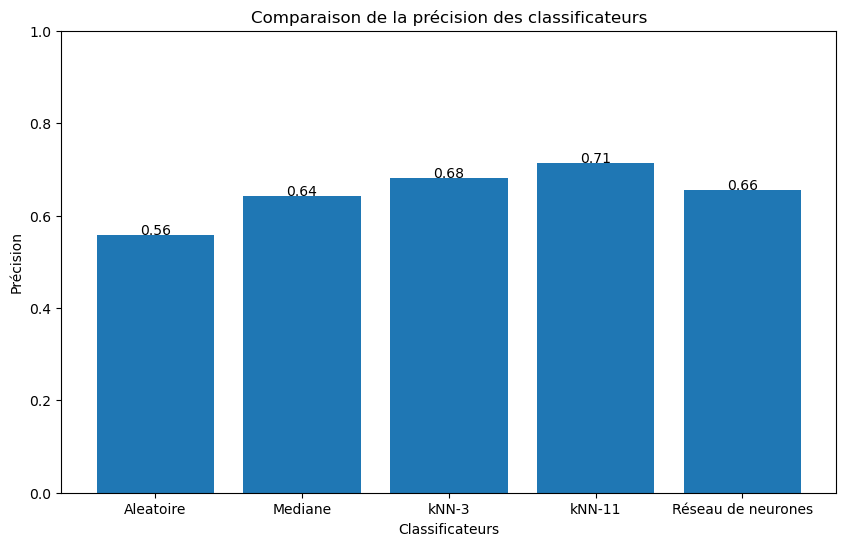

In [823]:
compare_classificateurs(carac, etiq, 0.8)

# Nettoyer les données

Si on affiche les données, on se rend compte que la notion de distance n'est pas forcément pertinente, car les échelles des distances sont différentes.

In [824]:
def affiche_donnees(carac, etiq, champs_a_afficher):
    fig = plt.figure(figsize=(10, 10))

    dims = [ champs.index(c) for c in champs_a_afficher ]
    # Boucler sur les étiquettes et les points pour les dessiner avec la couleur correspondante
    for outcome in [0, 1]:
        n = len(carac)
        data = [
            [ carac[i][d] for i in range(n) if etiq[i] == outcome ]
            for d in dims
        ]
        plt.scatter(data[0], data[1], label=outcome, s=3, alpha=0.5)

    plt.xlabel(champs_a_afficher[0])
    plt.ylabel(champs_a_afficher[1])
    plt.axis('equal')
    plt.legend()
    plt.show()

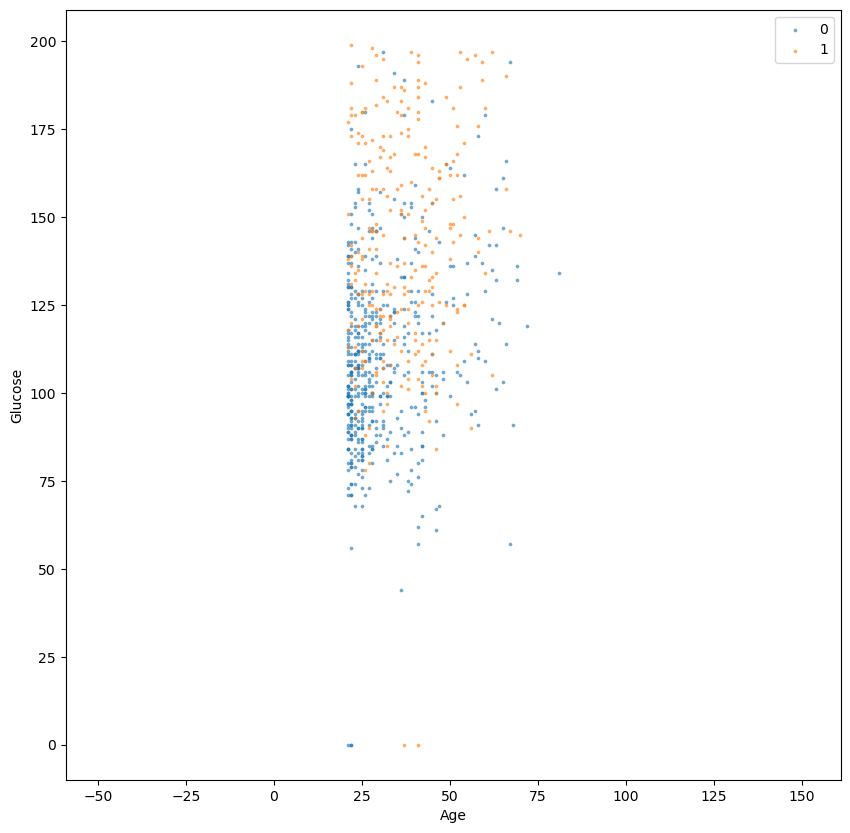

In [825]:
affiche_donnees(carac, etiq, ['Age', 'Glucose'])

Une manière simple de résoudre ce problème est de redimensionner chaque donnée entre 0 et 1. Cela ne change pas la *forme* de la distribution, notamment cela ne l'étale pas, mais cela lui permet d'être comparée avec les autres.

In [826]:
from scipy import stats

def redimensionne_dim(tab, i): # ramène la ième dimension entre 0 et 1
    valeurs = [ t[i] for t in tab ]
    max_valeur, min_valeur = max(valeurs), min(valeurs)
    return [ (t[i]-min_valeur)/(max_valeur-min_valeur) for t in tab ]

def redimensionne(tab):
    return transpose([ redimensionne_dim(tab,i) for i in range(len(tab[0])) ])

In [827]:
carac_r = redimensionne(carac)

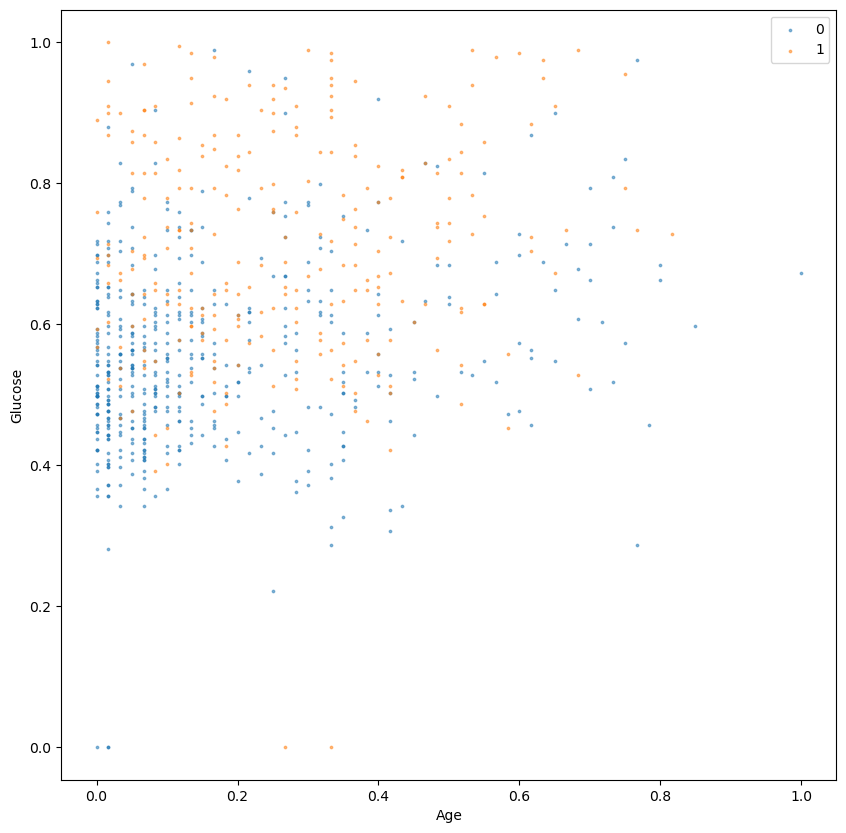

In [828]:
affiche_donnees(carac_r, etiq, ['Age', 'Glucose'])

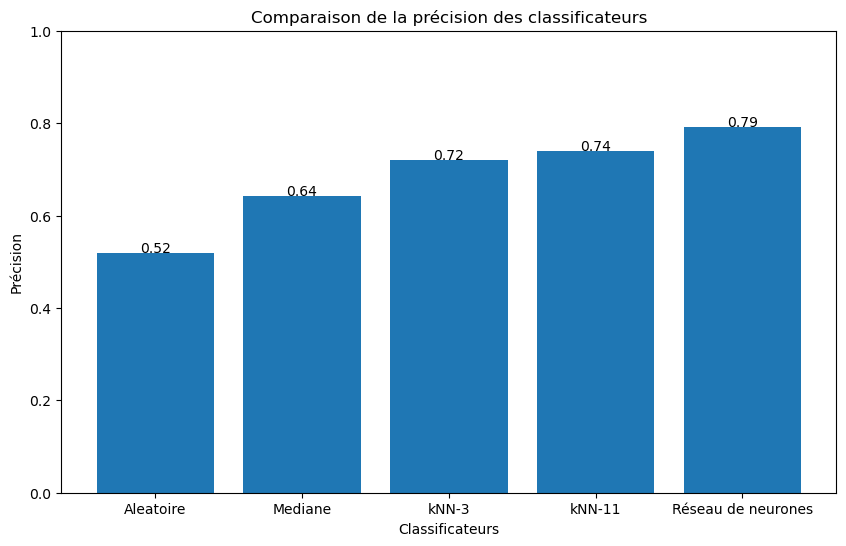

In [829]:
compare_classificateurs(carac_r, etiq, 0.8)

* **Question** que constate-t-on ?